In [1]:
import sys
sys.path.append('/shellstrop1/feilongm/radmc3d-2.0-master/python/radmc3dPy') #edit to match your path

import radmc3dPy

im = radmc3dPy.image.readImage(fname='/data/feilongm/HD163296_radmc3d/image.out') #edit to match the path to the image
im.writeFits('testimage.fits', dpc=101., coord='17h56m21s -21d57m21s')

Fast (Fortran90) Mie-scattering module could not be imported. Falling back to the slower Python version.
Reading /data/feilongm/HD163296_radmc3d/image.out
testimage.fits already exists
Do you want to overwrite it (yes/no)?yes


SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    3 / number of array dimensions                     NAXIS1  =                  512                                                  NAXIS2  =                  512                                                  NAXIS3  =                   81                                                  EXTEND  =                    T                                                  CRPIX1  =                256.5 /                                                CDELT1  = -6.4459570957095E-06                                                  CRVAL1  =             269.0875                                                  CUNIT1  = '     DEG'                                                            CTYPE1  = 'RA---SIN'                                                            CRPIX2  =                256.5          

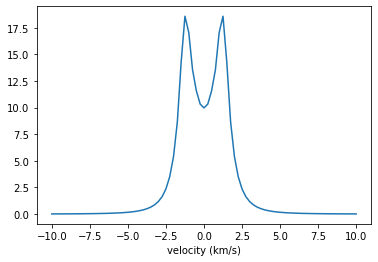

In [2]:
from astropy.io import fits
import numpy as np
from numpy import array, newaxis
from astropy import units as u
import matplotlib.pyplot as plt

HD163296_test_file = "/home/feilongm/testimage.fits"

HD163296_testcube = fits.open(HD163296_test_file)[0]

data = HD163296_testcube.data
data = np.squeeze(data)
spectrum = np.sum(data, axis=(1,2))

header = HD163296_testcube.header
print(header)

print("Reference frequency:",header['CRVAL3'] * u.Hz)
print("Reference frequency channel:",header['CRPIX3'])
print("Frequency spacing:",header['CDELT3'] * u.Hz)
print("Number of different frequencies:",header['NAXIS3'])
print("Unit of frequency:",header['CUNIT3'])
RESTFRQ = 230.538 * 10**9 *u.Hz
print(RESTFRQ)
numchannels = header['NAXIS3']

FrequencySpacing = header['CDELT3'] * u.Hz
ReferenceFrequency = header['CRVAL3'] * u.Hz
NumFreq = np.arange(start=1, stop=82, step=1)
RestFreq = RESTFRQ
c = 299792.458 * u.km / u.s

def FrequenciesOnDifferentChannals(FrequencySpacing, ReferenceFrequency, NumFreq):
    Freq = ReferenceFrequency + (NumFreq - 1) * FrequencySpacing
    return Freq

ResultReferenceFreq = FrequenciesOnDifferentChannals(FrequencySpacing, ReferenceFrequency, NumFreq)

print(ResultReferenceFreq)

def ConvertingUnits(ResultReferenceFreq, RestFreq):
    ConvertingUnits = c * (RestFreq - ResultReferenceFreq) / RestFreq
    return ConvertingUnits

resultVelocity = ConvertingUnits(ResultReferenceFreq, RestFreq)
print(resultVelocity)

plt.plot(resultVelocity, spectrum)
plt.xlabel('velocity (km/s)')
plt.show()

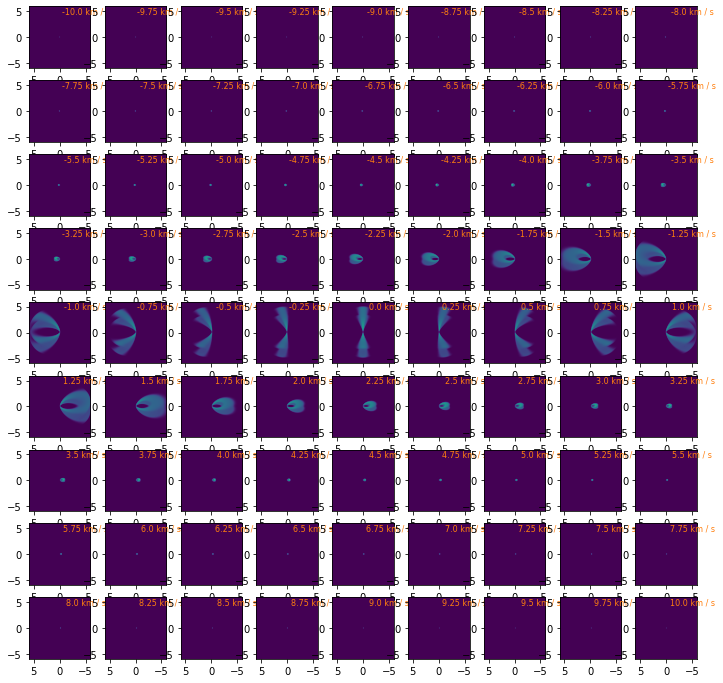

In [3]:
text_kwargs = dict(ha='center', va='center', fontsize=8, color='C1')
plt.figure(figsize = (12,12))
naxis1 = header['NAXIS1']
cdelt1 = header['CDELT1']*3600 #conversion to arcseconds
cdelt2 = header['CDELT2']*3600 #conversion to arcseconds
for i in range(1, 82):
    plt.subplot(9,9,i)
    plt.imshow(data[i-1], origin='lower', extent = [-0.5*cdelt1*naxis1, 0.5*cdelt1*naxis1,-0.5*cdelt2*naxis1, 0.5*cdelt2*naxis1] )
    text = np.round(resultVelocity[i-1], 2)
    plt.text(-5, 5, text, **text_kwargs)
plt.show()

In [9]:
import sys
import os
import numpy as np
from scipy.interpolate import LinearNDInterpolator
import matplotlib.pyplot as plt
import matplotlib.colors as col

#add parameters

def setDirectories(molname_in):
    """
    This function creates new directories (if not existed) named by the
    molecule we are studying and changes the current working directory
    to the directory specified in path.
        
    The `molname_in` parameter allows you to edit the name of the directory
    as you wish.
        
    Args:
        molname_in (str) : name [no units] of the molecule that
            we want to investigate.
                
    Returns:
        This function returns nothing.
    """
    path = '/data/feilongm/' + molname_in
    if not os.path.exists(path):
        os.system('mkdir ' + path)
    os.chdir(path)

def load_output():
    """
    This function extracts useful infromation in a file called 'iter_0001.dat'
    that describes the chemical and physical properties of a modeling protoplanetary
    disk.
    It creates and then returns a dictionary based on the information in
    'iter_0001.dat' file.
        
    Args:
        This function has no argument.
                
    Returns:
        dictionary (dict) : pairs of various properties and corresponding numerical values
        of the modeling protoplanetary disk. 
    """
    filename='/data/feilongm/rac-2d/rac-2d-master_2021/storage/HD_163296_COdep_t1e4_3/iter_0001.dat'
    output = np.loadtxt(filename, comments='!')
    with open(filename, 'r') as f:
        columnnames = f.readline().split()[1:]
        return dict(zip(np.array(columnnames), output.T))

def saveFile(results):
    """
    This function saves structural information of the modeling protoplanetary disk extracted
    from a dictonary that is passed into this function as a free parameter.
    It also adds a specific path for users to search.
        
    Args:
        results (dict) : pairs of various properties and corresponding numerical values
        of the modeling protoplanetary disk.
                
    Returns:
        This function returns nothing. 
    """
    import radmc3dPy
    import radmc3dPy.natconst as nc
    rac2d_rvals = 0.5*(results['rmin']+results['rmax'])
    rac2d_zvals = 0.5*(results['zmin']+results['zmax'])
    rac2d_ngas = results['n_gas']
    rac2d_temp = results['Tgas']
    outputarray = np.stack((rac2d_rvals, rac2d_zvals, rac2d_ngas,rac2d_temp), axis=-1)
    np.savetxt('HD163296structure.txt',outputarray)
    sys.path.append('/shellstrop1/feilongm/radmc3d-2.0-master/python/radmc3dPy')

def setModelGrid(mstar_in, gasspec_vturb_in):
    """
    This function enables us to create and return a customized model grid using two free
    parameters 'mstar_in' and 'gasspec_vturb_in'.
        
    Args:
        mstar_in (float) : stellar mass in [gram].
        gasspec_vturb_in (float) : turbulent line broadening parameter in [cm/s].
                
    Returns:
        a newly created customized radmc3d model [no units].
    """
    import radmc3dPy.natconst as nc
    rvals = np.logspace(np.log10(0.01), np.log10(800),num=100)
    rvalstring='['
    for i in rvals:
        rvalstring+=('%0.2e' % i + "*au,")
    rvalstring=rvalstring[:-1]+']'
    model = radmc3dPy.setup.radmc3dModel(model='ppdisk', 
                                         mstar = [mstar_in], #custom mstar
                                         gasspec_vturb = gasspec_vturb_in, #custom gasspec_vturb
                                         binary=False)
    model.par.ppar['crd_sys']  = 'sph'
    model.makeGrid()
    model.grid.act_dim = [1,1,0]
    model.grid.nxi = 256
    model.grid.nyi = 65
    model.grid.nzi = 2
    model.grid.xi = np.logspace(np.log10(0.1*nc.au), np.log10(600*nc.au), num=model.grid.nxi)
    model.grid.yi = np.concatenate((np.linspace(0, np.pi/3, num=20)[:-1], np.linspace(np.pi/3., np.pi/2., num=model.grid.nyi+1-20) )) #in radians
    model.grid.zi = np.array([0,0]) 
    model.grid.nx = model.grid.nxi-1
    model.grid.ny = model.grid.nyi-1
    model.grid.nz = model.grid.nzi-1
    model.grid.x = (model.grid.xi[1:]+model.grid.xi[:-1])*0.5
    model.grid.y = (model.grid.yi[1:]+model.grid.yi[:-1])*0.5
    model.grid.z = np.array([0])
    model.grid.writeSpatialGrid()
    model.grid.writeWavelengthGrid()
    model.data = radmc3dPy.analyze.radmc3dData(model.grid)
    model.makeRadSources(writeToFile=True)
    model.makeVar(gvel=True, vturb=True, writeToFile=True)
    return model

def writeGasTemp(radmc3dpy_model, structurefile):
    """
    This function enables us to write desired gas temperature to the model that we specified.
    The second parameter 'structurefile' here is for the convinence of reusing this function 
    in function WriteIn(...) described in this notebook later. It has no use in this particular
    case.
        
    Args:
        radmc3dpy_model (class) : a radmc3d model with various properties and corresponding values.
        structurefile (str) : path to the appropriate file.
                
    Returns:
        This function returns nothing.
    """
    import radmc3dPy.natconst as nc
    nx = radmc3dpy_model.data.grid.nx
    ny = radmc3dpy_model.data.grid.ny
    nz = radmc3dpy_model.data.grid.nz
    radmc3d_temp = np.zeros([nx, ny, nz])
    HD163296structure = np.loadtxt(structurefile)
    rac2d_r = HD163296structure[:,0]*nc.au 
    rac2d_z = HD163296structure[:,1]*nc.au 
    rac2d_temp =  HD163296structure[:,3] 
    
    rac2d_r = np.concatenate((rac2d_r, rac2d_r))
    rac2d_z = np.concatenate((rac2d_z, -1*rac2d_z))
    rac2d_temp =  np.concatenate((rac2d_temp, rac2d_temp))

    
    temp_interp = LinearNDInterpolator(list(zip(rac2d_r, rac2d_z)), rac2d_temp, fill_value=3.)
    
    
    for i in range(nx):
        for j in range(ny):
            for k in range(nz):
                r_cyl = radmc3dpy_model.data.grid.x[i]*np.sin(radmc3dpy_model.data.grid.y[j])
                z = np.abs(radmc3dpy_model.data.grid.x[i]*np.cos(radmc3dpy_model.data.grid.y[j]))
                tempval = temp_interp(r_cyl,z)
                if tempval>1.e5:
                    radmc3d_temp[i,j,k] = 99999.
                else:
                    radmc3d_temp[i,j,k] = temp_interp(r_cyl,z)
                
    radmc3dpy_model.data.gastemp = radmc3d_temp
    radmc3dpy_model.data.writeGasTemp(binary=False)

def writeCONumDens(radmc3dpy_model, structurefile, upperheight_in, lowerheight_in, molname, RAF):
    """
    This function allows us to use free parameters to generate CO density and write it into the
    model we choose.
    The second parameter 'structurefile' here is for the convinence of reusing this function 
    in function WriteIn(...) described in this notebook later. It has no use in this particular
    case.
        
    Args:
        radmc3dpy_model (class) : a radmc3d model with various properties and corresponding values.
        structurefile (str) : path to the appropriate file.
        upperheight_in (float) : upper height of the CO layer [no units].
        lowerheight_in (float) : lower height of the CO layer [no units].
        molname (str) : name of the molecule [no units].
        RAF (float) : relative abundance factor [no units].
                
    Returns:
        This function returns nothing.
    """
    import radmc3dPy.natconst as nc
    nx = radmc3dpy_model.data.grid.nx
    ny = radmc3dpy_model.data.grid.ny
    nz = radmc3dpy_model.data.grid.nz
    radmc3d_CONumDens = np.zeros([nx, ny, nz])
    HD163296structure = np.loadtxt(structurefile)
    rac2d_r = HD163296structure[:,0]*nc.au 
    rac2d_z = HD163296structure[:,1]*nc.au 
    rac2d_ngas = HD163296structure[:,2] 
    
    rac2d_r = np.concatenate((rac2d_r, rac2d_r))
    rac2d_z = np.concatenate((rac2d_z, -1*rac2d_z))
    rac2d_ngas =  np.concatenate((rac2d_ngas, rac2d_ngas))
    
    logngasinterp = LinearNDInterpolator(list(zip(rac2d_r, rac2d_z)), np.log10(rac2d_ngas),fill_value=1.e-20)
    
    for i in range(nx):
        for j in range(ny):
            for k in range(nz):
                r_cyl = radmc3dpy_model.data.grid.x[i]*np.sin(radmc3dpy_model.data.grid.y[j])
                z = np.abs(radmc3dpy_model.data.grid.x[i]*np.cos(radmc3dpy_model.data.grid.y[j]))
                ngas = 10**logngasinterp(r_cyl,z)
                if lowerheight_in< z/r_cyl < upperheight_in:
                    radmc3d_CONumDens[i,j,k] = RAF*ngas
                else:
                    radmc3d_CONumDens[i,j,k] = 1.e-20
    radmc3dpy_model.data.ndens_mol = radmc3d_CONumDens
    radmc3dpy_model.data.writeGasDens(ispec=molname,binary=False)

def writeIn(upperheight_in, lowerheight_in, molname_in, model_in, structurefile, RAF):
    """
    This function encapsulates function writeGasTemp(...) and writeCONumDens(...). It is for the
    purpose of bing used as a "summative function" to reduce code redundancy.
        
    Args:
        model_in (class) : a radmc3d model with various properties and corresponding values.
        structurefile (str) : path to the appropriate file.
        upperheight_in (float) : upper height of the CO layer [no units].
        lowerheight_in (float) : lower height of the CO layer [no units].
        molname (str) : name of the molecule [no units].
        RAF (float) : relative abundance factor [no units].
                
    Returns:
        This function returns nothing.
    """
    import radmc3dPy.natconst as nc
    HD163296file = '/data/feilongm/HD163296_radmc3d/HD163296structure.txt' #change to appropriate path as needed
    writeGasTemp(model_in, HD163296file)
    writeCONumDens(model_in, HD163296file, upperheight_in, lowerheight_in, molname_in, RAF)

def copyDataAndWriteFile(molname, model_in):
    """
    This function copies over CO line data to directories specified by the name of the molecule and
    writes radmc3d input files.
        
    Args:
        molname (str) : name of the molecule [no units].
        model_in (class) : a radmc3d model with various properties and corresponding values.
                
    Returns:
        This function returns nothing.
    """
    import os.path
    from os import path
    filename = 'molecule_'+ molname +'.inp'
    path = '/home/feilongm/' + filename + '.inp'
    if molname == 'co':
        os.system('cp -v /shellstrop1/feilongm/radmc3d-2.0-master/python/radmc3dPy/python_examples/datafiles/molecule_co.inp .') # change to correct path
    elif os.path.exists(filename):
        os.system('cp -v ' + path)
    model_in.par.ppar['gasspec_mol_name'] = [molname]
    model_in.writeLinesInp()
    model_in.par.ppar['lines_mode']=1
    model_in.par.ppar['tgas_eq_tdust']=0
    model_in.writeRadmc3dInp()

def simulateImageCube(incl_in, widthkms_in, linenlam_in, iline_in):
    """
    This function simulates an image cube.
        
    Args:
        incl_in (float) : disk inclination angle in [degree].
        widthkms_in (float) : frequencies in [km/s].
        linenlam_in (int) : number of wavelengths [no units] at which to calculate the spectrum.
        iline_in (int) : number of molecular transition to simulate [no units].
                
    Returns:
        This function returns nothing.
    """
    radmc3dPy.image.makeImage(npix=512.,
                          incl=incl_in,
                          phi=0.,
                          sizeau=1200.,
                          widthkms=widthkms_in,
                          linenlam=linenlam_in,
                          iline=iline_in)
    
def saveAsFits(molname_in):
    """
    This function saves different molecule image output files as fits files.
        
    Args:
        model_in (class) : a radmc3d model with various properties and corresponding values.
                
    Returns:
        This function returns nothing.
    """
    im = radmc3dPy.image.readImage(fname='/data/feilongm/' + molname_in + '/image.out') #edit to match the path to the image
    im.writeFits('testimage' + molname_in + '.fits', dpc=101., coord='17h56m21s -21d57m21s')

def notification():
    """
    This function reminds users that the excution inside the current cell is completed.
        
    Args:
        This function has no arguments.
                
    Returns:
        This function returns nothing.
    """
    print("Fits file has been successfully generated!")

In [5]:
def RADMC3D(molname_in, iline_in, mstar_in, gasspec_vturb_in, lowerheight_in, upperheight_in, RAF, incl_in, widthkms_in, linenlam_in):
    """
    This function glues all the functions described in the previous cell together to 
    reduce a lot of code redundancies in generating models with various combinations of
    parameters.
        
    Args:
        molname_in (str) : name of the molecule [no units].
        iline_in (int) : number of molecular transition to simulate [no units].
        mstar_in (float) : stellar mass in [gram].
        gasspec_vturb_in (float) : turbulent line broadening parameter in [cm/s].
        lowerheight_in (float) : lower height of the CO layer [no units].
        upperheight_in (float) : upper height of the CO layer [no units].
        RAF (float) : relative abundance factor [no units].
        incl_in (float) : disk inclination angle in [degree].
        widthkms_in (float) : frequencies in [km/s].
        linenlam_in (int) : number of wavelengths [no units] at which to calculate the spectrum.
                
    Returns:
        This function returns nothing.
    """
    setDirectories(molname_in)
    results = load_output()
    saveFile(results)
    model_in = setModelGrid(mstar_in, gasspec_vturb_in)
    writeIn(upperheight_in, lowerheight_in, molname_in, model_in)
    copyDataAndWriteFile(molname_in, model_in)
    simulateImageCube(incl_in, widthkms_in, linenlam_in, iline_in)
    saveAsFits(molname_in)
    notification()

molname_in = 'co'
iline_in = 2
mstar_in = 4.e33
gasspec_vturb_in = 1.e4
upperheight_in = 0.25
lowerheight_in = 0.15
RAF = 1.e-5
incl_in = 46.7
widthkms_in = 10
linenlam_in = 81

RADMC3D(molname_in, iline_in, mstar_in, gasspec_vturb_in, lowerheight_in, upperheight_in, RAF, incl_in, widthkms_in, linenlam_in)

Writing problem_params.inp
Writing amr_grid.inp
Writing wavelength_micron.inp
Writing stars.inp
-------------------------------------------------------------
Luminosities of radiation sources in the model :
Reading wavelength_micron.inp
As calculated from the input files :
Stars : 
  Star #0 + hotspot        : 3.564346e+33
Continuous starlike source : 0.000000e+00
 
-------------------------------------------------------------
Writing gas_velocity.inp
Writing microturbulence.inp
Writing gas_temperature.inp
Writing numberdens_co.inp
Writing lines.inp
Writing radmc3d.inp
Executing RADMC-3D Command:
radmc3d image npix 512 incl 46.7 sizeau 1200.0 widthkms 10 linenlam 81 phi 0.0 pointau 0.0  0.0  0.0 fluxcons iline 2
Reading /data/feilongm/co/image.out
testimageco.fits already exists
Do you want to overwrite it (yes/no)?yes
Fits file has been successfully generated!


In [6]:
molname_in = 'hcn'
iline_in = 13
mstar_in = 4.e33
gasspec_vturb_in = 1.e4
upperheight_in = 0.25
lowerheight_in = 0.15
RAF = 1.e-8
incl_in = 46.7
widthkms_in = 10
linenlam_in = 81

RADMC3D(molname_in, iline_in, mstar_in, gasspec_vturb_in, lowerheight_in, upperheight_in, RAF, incl_in, widthkms_in, linenlam_in)

Writing problem_params.inp
Writing amr_grid.inp
Writing wavelength_micron.inp
Writing stars.inp
-------------------------------------------------------------
Luminosities of radiation sources in the model :
Reading wavelength_micron.inp
As calculated from the input files :
Stars : 
  Star #0 + hotspot        : 3.564346e+33
Continuous starlike source : 0.000000e+00
 
-------------------------------------------------------------
Writing gas_velocity.inp
Writing microturbulence.inp
Writing gas_temperature.inp
Writing numberdens_hcn.inp
Writing lines.inp
Writing radmc3d.inp
Executing RADMC-3D Command:
radmc3d image npix 512 incl 46.7 sizeau 1200.0 widthkms 10 linenlam 81 phi 0.0 pointau 0.0  0.0  0.0 fluxcons iline 13
Reading /data/feilongm/hcn/image.out
testimagehcn.fits already exists
Do you want to overwrite it (yes/no)?yes
Fits file has been successfully generated!


In [7]:
molname_in = 'c2h'
iline_in = 21
mstar_in = 4.e33
gasspec_vturb_in = 1.e4
upperheight_in = 0.25
lowerheight_in = 0.15
RAF = 1.e-8
incl_in = 46.7
widthkms_in = 10
linenlam_in = 81

RADMC3D(molname_in, iline_in, mstar_in, gasspec_vturb_in, lowerheight_in, upperheight_in, RAF, incl_in, widthkms_in, linenlam_in)

Writing problem_params.inp
Writing amr_grid.inp
Writing wavelength_micron.inp
Writing stars.inp
-------------------------------------------------------------
Luminosities of radiation sources in the model :
Reading wavelength_micron.inp
As calculated from the input files :
Stars : 
  Star #0 + hotspot        : 3.564346e+33
Continuous starlike source : 0.000000e+00
 
-------------------------------------------------------------
Writing gas_velocity.inp
Writing microturbulence.inp
Writing gas_temperature.inp
Writing numberdens_c2h.inp
Writing lines.inp
Writing radmc3d.inp
Executing RADMC-3D Command:
radmc3d image npix 512 incl 46.7 sizeau 1200.0 widthkms 10 linenlam 81 phi 0.0 pointau 0.0  0.0  0.0 fluxcons iline 21
Reading /data/feilongm/c2h/image.out
testimagec2h.fits already exists
Do you want to overwrite it (yes/no)?yes
Fits file has been successfully generated!


SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    3 / number of array dimensions                     NAXIS1  =                  512                                                  NAXIS2  =                  512                                                  NAXIS3  =                   81                                                  EXTEND  =                    T                                                  CRPIX1  =                256.5 /                                                CDELT1  = -6.4459570957095E-06                                                  CRVAL1  =             269.0875                                                  CUNIT1  = '     DEG'                                                            CTYPE1  = 'RA---SIN'                                                            CRPIX2  =                256.5          

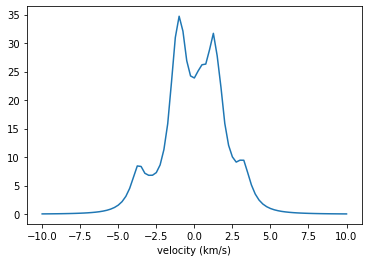

In [3]:
from astropy.io import fits
import numpy as np
from numpy import array, newaxis
from astropy import units as u
import matplotlib.pyplot as plt

HD163296_test_file = "/data/feilongm/hcn/testimagehcn.fits"

HD163296_testcube = fits.open(HD163296_test_file)[0]

data = HD163296_testcube.data
data = np.squeeze(data)
spectrum = np.sum(data, axis=(1,2))

header = HD163296_testcube.header
print(header)

print("Reference frequency:",header['CRVAL3'] * u.Hz)
print("Reference frequency channel:",header['CRPIX3'])
print("Frequency spacing:",header['CDELT3'] * u.Hz)
print("Number of different frequencies:",header['NAXIS3'])
print("Unit of frequency:",header['CUNIT3'])
RESTFRQ = 265.88649990 * 10**9 *u.Hz
print(RESTFRQ)
numchannels = header['NAXIS3']

FrequencySpacing = header['CDELT3'] * u.Hz
ReferenceFrequency = header['CRVAL3'] * u.Hz
NumFreq = np.arange(start=1, stop=82, step=1)
RestFreq = RESTFRQ
c = 299792.458 * u.km / u.s

def FrequenciesOnDifferentChannals(FrequencySpacing, ReferenceFrequency, NumFreq):
    Freq = ReferenceFrequency + (NumFreq - 1) * FrequencySpacing
    return Freq

ResultReferenceFreq = FrequenciesOnDifferentChannals(FrequencySpacing, ReferenceFrequency, NumFreq)

print(ResultReferenceFreq)

def ConvertingUnits(ResultReferenceFreq, RestFreq):
    ConvertingUnits = c * (RestFreq - ResultReferenceFreq) / RestFreq
    return ConvertingUnits

resultVelocity = ConvertingUnits(ResultReferenceFreq, RestFreq)
print(resultVelocity)

plt.plot(resultVelocity, spectrum)
plt.xlabel('velocity (km/s)')
plt.show()

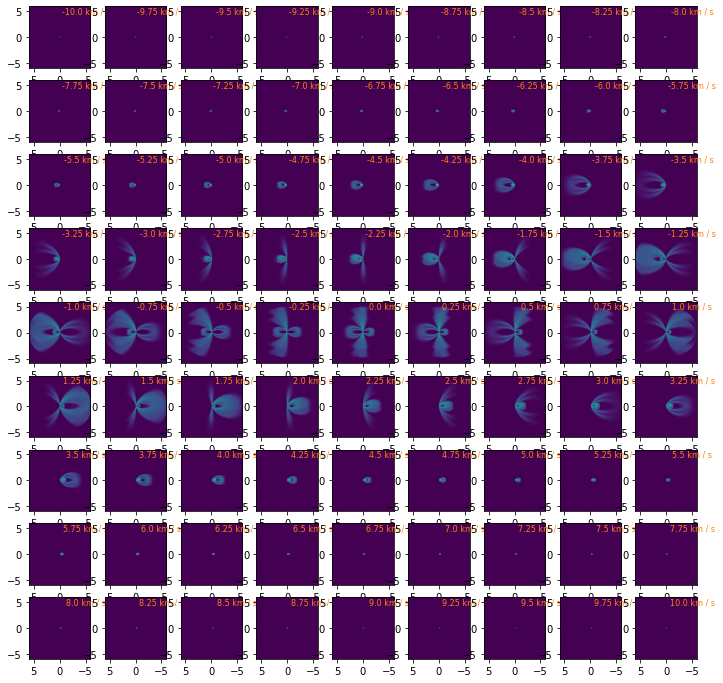

In [4]:
text_kwargs = dict(ha='center', va='center', fontsize=8, color='C1')
plt.figure(figsize = (12,12))
naxis1 = header['NAXIS1']
cdelt1 = header['CDELT1']*3600 #conversion to arcseconds
cdelt2 = header['CDELT2']*3600 #conversion to arcseconds
for i in range(1, 82):
    plt.subplot(9,9,i)
    plt.imshow(data[i-1], origin='lower', extent = [-0.5*cdelt1*naxis1, 0.5*cdelt1*naxis1,-0.5*cdelt2*naxis1, 0.5*cdelt2*naxis1] )
    text = np.round(resultVelocity[i-1], 2)
    plt.text(-5, 5, text, **text_kwargs)
plt.show()

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    3 / number of array dimensions                     NAXIS1  =                  512                                                  NAXIS2  =                  512                                                  NAXIS3  =                   81                                                  EXTEND  =                    T                                                  CRPIX1  =                256.5 /                                                CDELT1  = -6.4459570957095E-06                                                  CRVAL1  =             269.0875                                                  CUNIT1  = '     DEG'                                                            CTYPE1  = 'RA---SIN'                                                            CRPIX2  =                256.5          

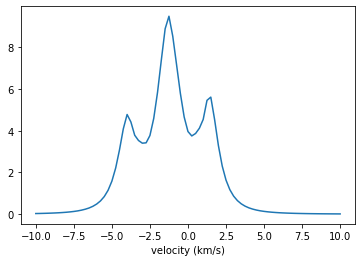

In [5]:
HD163296_test_file = "/data/feilongm/c2h/testimagec2h.fits"

HD163296_testcube = fits.open(HD163296_test_file)[0]

data = HD163296_testcube.data
data = np.squeeze(data)
spectrum = np.sum(data, axis=(1,2))

header = HD163296_testcube.header
print(header)

print("Reference frequency:",header['CRVAL3'] * u.Hz)
print("Reference frequency channel:",header['CRPIX3'])
print("Frequency spacing:",header['CDELT3'] * u.Hz)
print("Number of different frequencies:",header['NAXIS3'])
print("Unit of frequency:",header['CUNIT3'])
RESTFRQ = 262.00426 * 10**9 *u.Hz
print(RESTFRQ)
numchannels = header['NAXIS3']

FrequencySpacing = header['CDELT3'] * u.Hz
ReferenceFrequency = header['CRVAL3'] * u.Hz
NumFreq = np.arange(start=1, stop=82, step=1)
RestFreq = RESTFRQ
c = 299792.458 * u.km / u.s

def FrequenciesOnDifferentChannals(FrequencySpacing, ReferenceFrequency, NumFreq):
    Freq = ReferenceFrequency + (NumFreq - 1) * FrequencySpacing
    return Freq

ResultReferenceFreq = FrequenciesOnDifferentChannals(FrequencySpacing, ReferenceFrequency, NumFreq)

print(ResultReferenceFreq)

def ConvertingUnits(ResultReferenceFreq, RestFreq):
    ConvertingUnits = c * (RestFreq - ResultReferenceFreq) / RestFreq
    return ConvertingUnits

resultVelocity = ConvertingUnits(ResultReferenceFreq, RestFreq)
print(resultVelocity)

plt.plot(resultVelocity, spectrum)
plt.xlabel('velocity (km/s)')
plt.show()

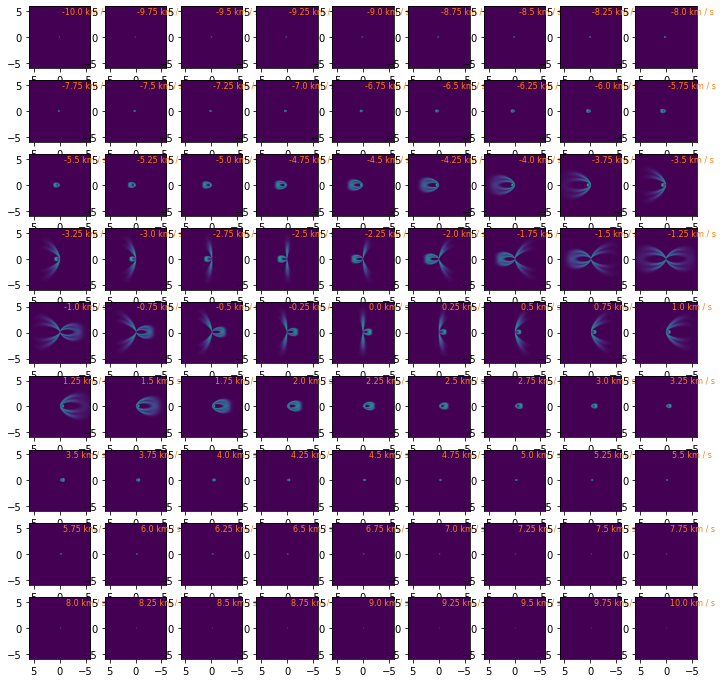

In [6]:
text_kwargs = dict(ha='center', va='center', fontsize=8, color='C1')
plt.figure(figsize = (12,12))
naxis1 = header['NAXIS1']
cdelt1 = header['CDELT1']*3600 #conversion to arcseconds
cdelt2 = header['CDELT2']*3600 #conversion to arcseconds
for i in range(1, 82):
    plt.subplot(9,9,i)
    plt.imshow(data[i-1], origin='lower', extent = [-0.5*cdelt1*naxis1, 0.5*cdelt1*naxis1,-0.5*cdelt2*naxis1, 0.5*cdelt2*naxis1] )
    text = np.round(resultVelocity[i-1], 2)
    plt.text(-5, 5, text, **text_kwargs)
plt.show()